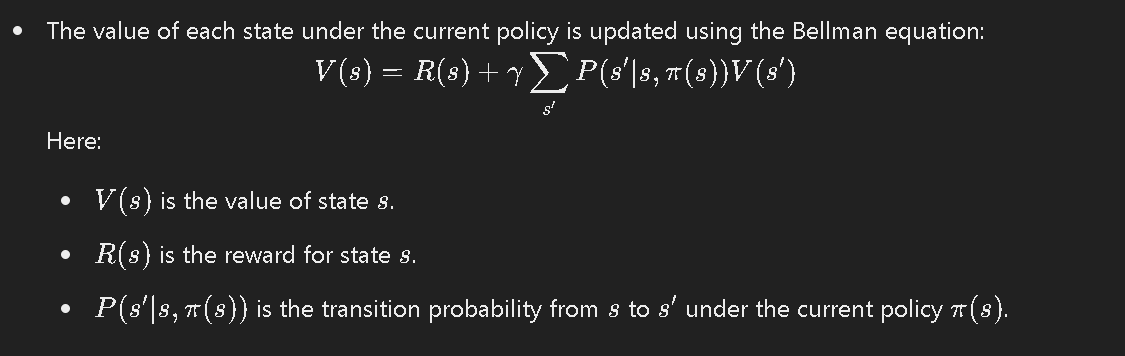

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid world setup and transition model
def create_grid_world(r):
    # Reward function for the grid world
    rewards = np.full(9, -1)  # Default reward of -1 for all states
    rewards[0] = r  # Terminal state at the upper-left corner
    rewards[2] = 10  # Terminal state at the upper-right corner

    # Transition model
    transitions = np.zeros((9, 4, 9))  # 9 states, 4 actions (Up, Down, Left, Right)

    # Directions: Up = 0, Down = 1, Left = 2, Right = 3
    directions = [(-3, 0), (3, 0), (0, -1), (0, 1)]  # (row, column) offsets
    for state in range(9):
        if state in [0, 2]:  # Skip terminal states
            continue
        for action in range(4):
            intended_direction = directions[action]
            intended_state = state + intended_direction[0] + intended_direction[1]

            # Check for boundary conditions (stay in place if invalid)
            if intended_state < 0 or intended_state >= 9:
                intended_state = state

            # 80% probability to go in the intended direction
            transitions[state, action, intended_state] += 0.8

            # 10% probability for each perpendicular direction
            for perp_action in [(action + 1) % 4, (action + 3) % 4]:
                perp_direction = directions[perp_action]
                perp_state = state + perp_direction[0] + perp_direction[1]

                # Check for boundary conditions
                if perp_state < 0 or perp_state >= 9:
                    perp_state = state

                transitions[state, action, perp_state] += 0.1

    return rewards, transitions


## Policy Iteration


Epoch 1:
Policy Grid:
T ← T
↑ ← ←
↑ ↑ ←

Values Grid:
100.00 87.56 10.00
94.46 84.55 81.72
79.73 81.94 79.46


Epoch 2:
Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑

Values Grid:
100.00 88.47 10.00
96.78 93.69 91.28
93.96 90.98 88.60


Epoch 3:
Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑

Values Grid:
100.00 92.27 10.00
96.79 93.74 91.35
94.00 91.29 88.97


Final Policy:
Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑

Final Values:
Values Grid:
100.00 92.27 10.00
96.79 93.74 91.35
94.00 91.29 88.97



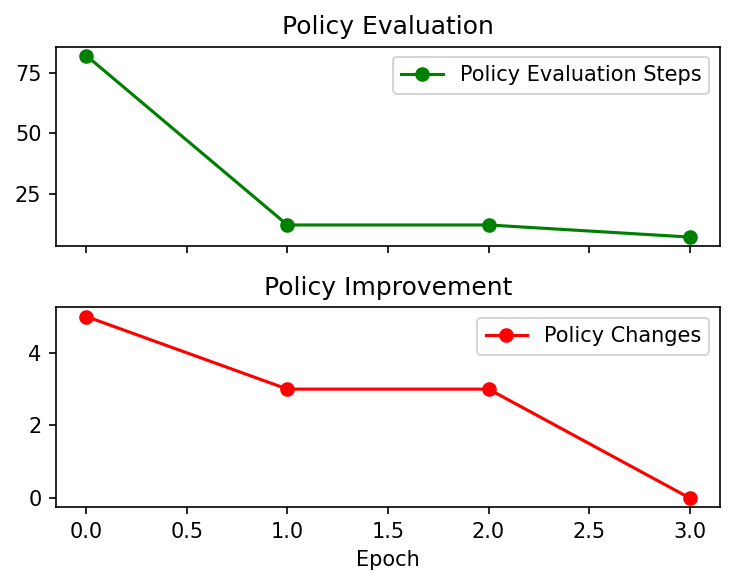


Epoch 1:
Policy Grid:
T → T
← → ↑
↑ ← ↑

Values Grid:
3.00 8.01 10.00
8.24 6.64 7.96
6.70 5.15 3.84


Epoch 2:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
3.00 8.01 10.00
8.30 7.17 8.28
6.81 5.64 6.93


Epoch 3:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.85 5.96 6.93


Final Policy:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Final Values:
Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.85 5.96 6.93



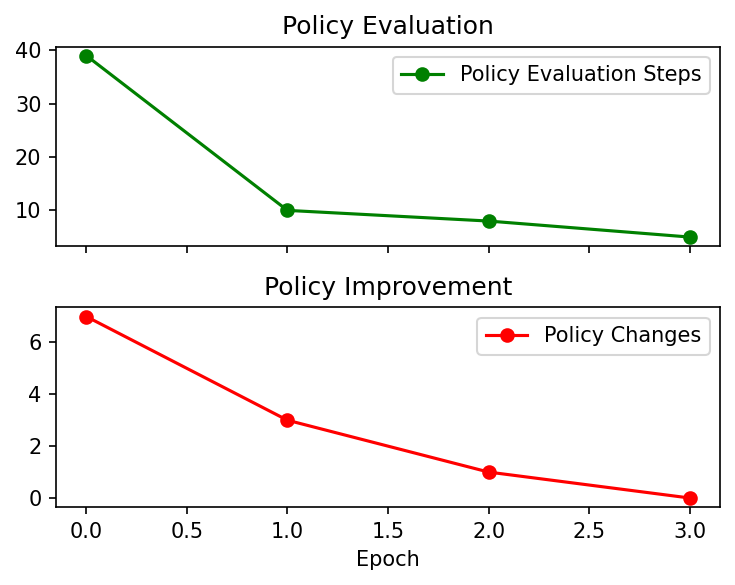


Epoch 1:
Policy Grid:
T → T
← → ↑
← → ↑

Values Grid:
0.00 7.68 10.00
8.22 6.43 8.27
6.70 5.30 6.92


Epoch 2:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.81 5.87 6.93


Epoch 3:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.84 5.93 6.93


Final Policy:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Final Values:
Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.84 5.93 6.93



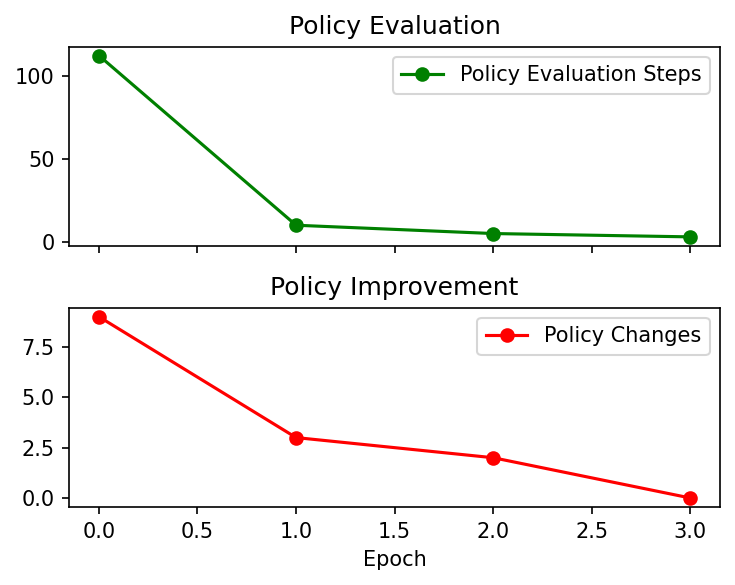


Epoch 1:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
-3.00 7.35 10.00
8.26 6.85 7.97
6.73 5.24 3.93


Epoch 2:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.90 6.93


Final Policy:
Policy Grid:
T → T
← → ↑
↑ ↑ ↑

Final Values:
Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.90 6.93



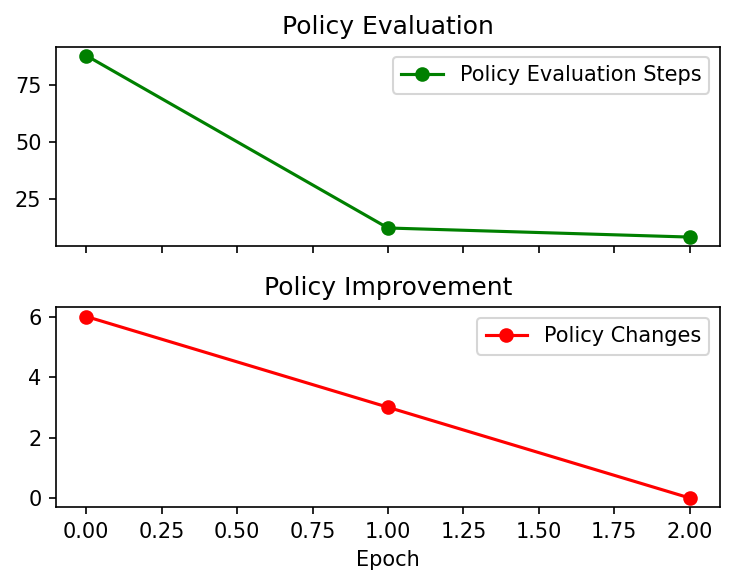

In [30]:


class PolicyIteration:
    def __init__(self, rewards, transitions, gamma, init_policy=None):
        self.num_states = len(rewards)
        self.num_actions = len(transitions[0])  # Number of actions
        self.rewards = np.nan_to_num(rewards)
        self.transitions = transitions
        self.gamma = gamma

        self.values = np.zeros(self.num_states)
        self.policy = (
            np.random.randint(0, self.num_actions, self.num_states)
            if init_policy is None
            else init_policy
        )

    def evaluate_policy(self):
        delta = 0
        for state in range(self.num_states):
            old_value = self.values[state]
            action = self.policy[state]
            probs = self.transitions[state, action]
            self.values[state] = self.rewards[state] + self.gamma * np.sum(probs * self.values)
            delta = max(delta, abs(old_value - self.values[state]))
        return delta

    def policy_evaluation(self, tol=1e-3):
        epochs = 0
        while epochs < 500:
            delta = self.evaluate_policy()
            if delta < tol:
                break
            epochs += 1
        return epochs

    def policy_improvement(self):
        changes = 0
        for state in range(self.num_states):
            old_action = self.policy[state]
            action_values = np.zeros(self.num_actions)
            for action in range(self.num_actions):
                probs = self.transitions[state, action]
                action_values[action] = np.sum(probs * self.values)
            self.policy[state] = np.argmax(action_values)
            if self.policy[state] != old_action:
                changes += 1
        return changes

    def train(self, tol=1e-3, plot=True):
        epoch = 0
        eval_epochs = self.policy_evaluation(tol)
        eval_history = [eval_epochs]
        policy_changes = self.policy_improvement()
        change_history = [policy_changes]

        while policy_changes > 0 and epoch < 500:
            epoch += 1
            eval_epochs = self.policy_evaluation(tol)
            eval_history.append(eval_epochs)
            policy_changes = self.policy_improvement()
            change_history.append(policy_changes)

            print(f"\nEpoch {epoch}:")
            self.print_grid(self.policy, "Policy")
            self.print_grid(self.values, "Values")

        print("\nFinal Policy:")
        self.print_grid(self.policy, "Policy")
        print("Final Values:")
        self.print_grid(self.values, "Values")

        if plot:
            self.plot_convergence(eval_history, change_history)

    def plot_convergence(self, eval_history, change_history):
        fig, axes = plt.subplots(2, 1, figsize=(5, 4), dpi=150, sharex=True)

        axes[0].plot(eval_history, marker='o', label='Policy Evaluation Steps', color='green')
        axes[0].set_title("Policy Evaluation")
        axes[0].legend()

        axes[1].plot(change_history, marker='o', label='Policy Changes', color='red')
        axes[1].set_title("Policy Improvement")
        axes[1].set_xlabel("Epoch")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def print_grid(self, data, title=""):
        grid_size = 3
        arrows = ['↑', '↓', '←', '→']
        print(f"{title} Grid:")
        for i in range(grid_size):
            row = []
            for j in range(grid_size):
                idx = i * grid_size + j
                if data is self.policy:
                    row.append('T' if idx in [0, 2] else arrows[data[idx]])
                elif data is self.values:
                    row.append(f"{data[idx]:.2f}")
            print(' '.join(row))
        print()


# Example usage
reward_values = [100, 3, 0, -3]
for r in reward_values:
    rewards, transitions = create_grid_world(r)
    pi = PolicyIteration(rewards, transitions, gamma=0.99)
    pi.train()


## Value Iteration

Values Grid:
100.00 92.27 10.00
96.79 93.74 91.35
94.00 91.29 88.97
Optimal Policy Grid:
T ↓ T
↑ ← ←
↑ ← ↑


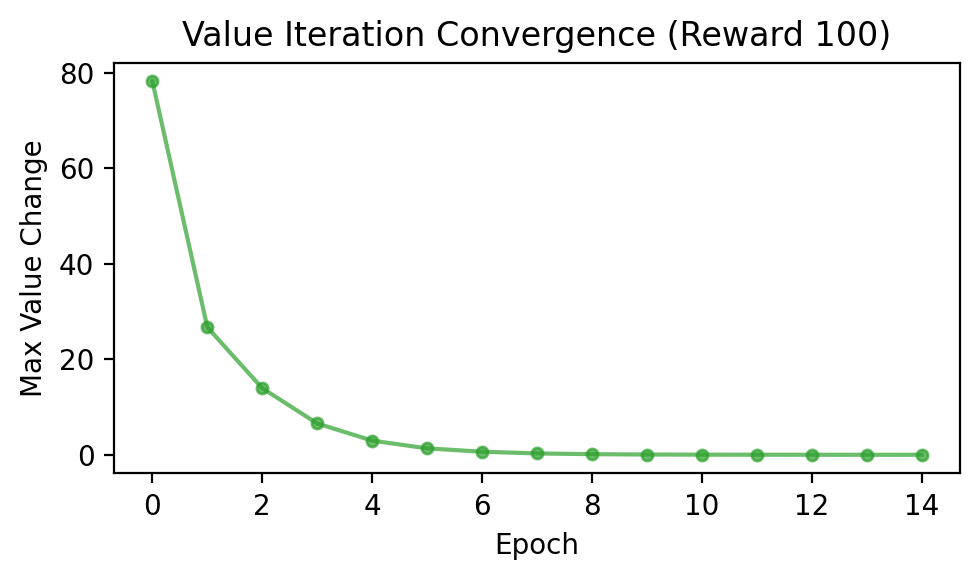

Values Grid:
3.00 8.01 10.00
8.31 7.18 8.28
6.85 5.96 6.93
Optimal Policy Grid:
T → T
← → ↑
↑ ↑ ↑


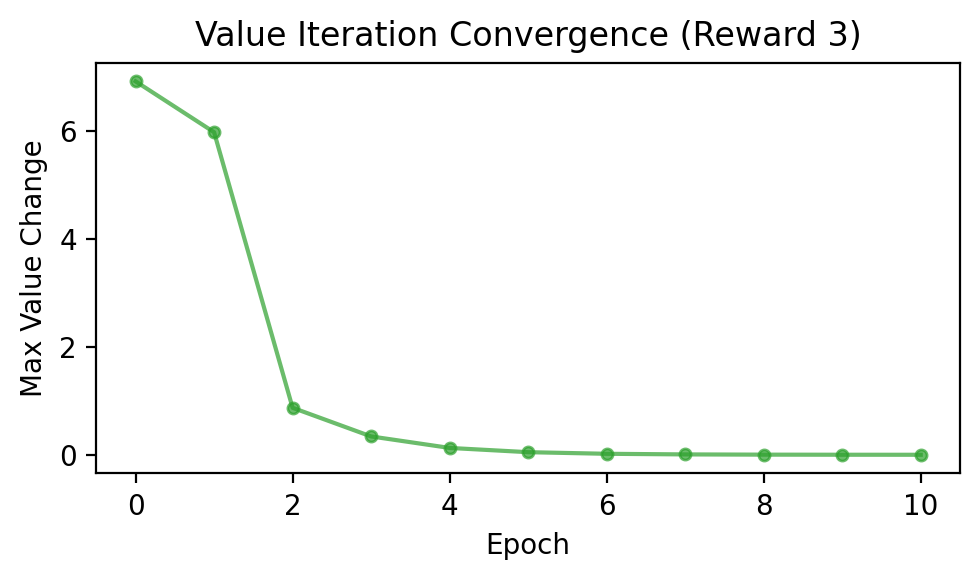

Values Grid:
0.00 7.68 10.00
8.30 7.14 8.28
6.84 5.93 6.93
Optimal Policy Grid:
T → T
← → ↑
↑ ↑ ↑


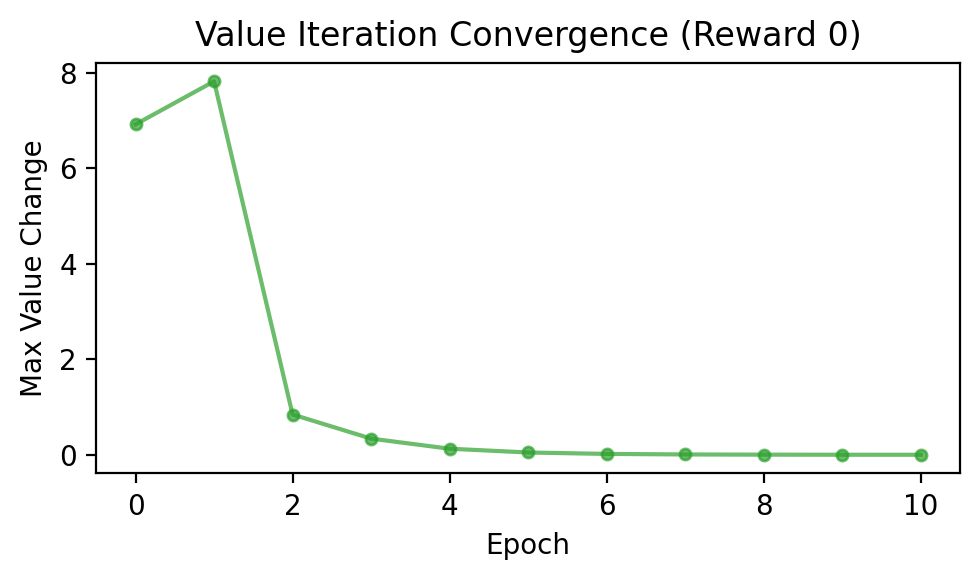

Values Grid:
-3.00 7.35 10.00
8.30 7.11 8.28
6.83 5.90 6.93
Optimal Policy Grid:
T → T
← → ↑
↑ ↑ ↑


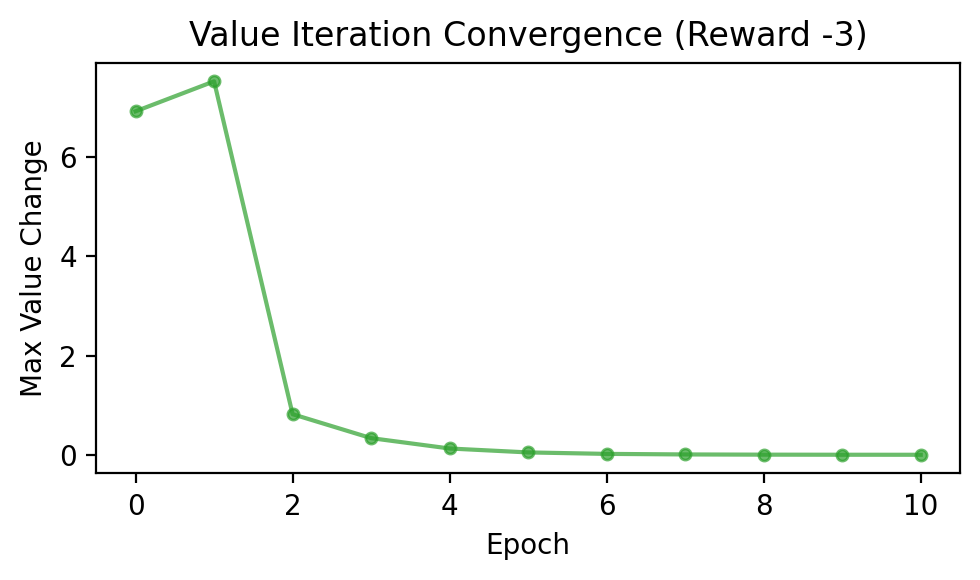

In [28]:
class ValueIteration:
    def __init__(self, reward_function, transition_model, gamma, init_values=None):
        self.num_states = len(reward_function)
        self.num_actions = len(transition_model[0])  # Number of actions
        self.reward_function = np.nan_to_num(reward_function)
        self.transition_model = transition_model
        self.gamma = gamma

        self.values = np.zeros(self.num_states)
        if init_values is not None:
            self.values = init_values  # Optional: Initialize with custom values
        self.policy = np.zeros(self.num_states, dtype=int)  # Optimal policy (actions)

    def one_value_iteration(self):
        delta = 0
        for s in range(self.num_states):
            if s == 0 or s == 2:  # Terminal states
                self.values[s] = self.reward_function[s]  # Ensure terminal state values match their rewards
                continue
            temp = self.values[s]
            value_list = np.zeros(self.num_actions)
            for a in range(self.num_actions):
                p = self.transition_model[s, a]
                value_list[a] = np.sum(p * self.values)  # Expected value for action `a`
            self.values[s] = self.reward_function[s] + self.gamma * np.max(value_list)
            self.policy[s] = np.argmax(value_list)  # Track the action with max value
            delta = max(delta, abs(temp - self.values[s]))

        return delta

    def run_value_iteration(self, tol=1e-3):
        epoch = 0
        delta_history = []
        while epoch < 500:
            delta = self.one_value_iteration()
            delta_history.append(delta)
            if delta < tol:  # Convergence check
                break
            epoch += 1
        return delta_history

    def print_values_grid(self):
        """ Helper function to print the values grid """
        grid_size = 3  # 3x3 grid
        value_grid = np.full((grid_size, grid_size), '---', dtype=object)  # Placeholder for values

        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                value_grid[i, j] = f"{self.values[idx]:.2f}"

        print("Values Grid:")
        for i in range(grid_size):
            print(' '.join(value_grid[i]))

    def print_optimal_policy(self):
        """ Helper function to print the optimal policy """
        grid_size = 3  # 3x3 grid
        action_map = ['↑', '↓', '←', '→']  # Mapping of actions (0 = ↑, 1 = ↓, 2 = ←, 3 = →)
        policy_grid = np.full((grid_size, grid_size), '---', dtype=object)

        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                if idx == 0 or idx == 2:  # Terminal states
                    policy_grid[i, j] = 'T'
                else:
                    policy_grid[i, j] = action_map[self.policy[idx]]

        print("Optimal Policy Grid:")
        for i in range(grid_size):
            print(' '.join(policy_grid[i]))

    def plot_convergence(self, delta_history, r):
        """ Function to plot convergence """
        plt.figure(figsize=(5, 3), dpi=200)
        plt.plot(np.arange(len(delta_history)), delta_history, marker='o', markersize=4, alpha=0.7, color='#2ca02c')
        plt.title(f"Value Iteration Convergence (Reward {r})")
        plt.xlabel("Epoch")
        plt.ylabel("Max Value Change")
        plt.tight_layout()
        plt.show()

# Example usage of ValueIteration
r_values = [100, 3, 0, -3]
for r in r_values:
    reward_function, transition_model = create_grid_world(r)
    value_iteration = ValueIteration(reward_function, transition_model, gamma=0.99)
    delta_history = value_iteration.run_value_iteration()
    value_iteration.print_values_grid()
    value_iteration.print_optimal_policy()
    value_iteration.plot_convergence(delta_history, r)
